# Data Preparation

In [84]:
from pandas import DataFrame
from datetime import datetime

In [85]:
class MVTSSample:
    
    def __init__(self, active_region:str, flare_class:str, flare_type:str, \
                 verification:str, start_time:datetime, end_time:datetime, data:DataFrame):
        self.flare_type = flare_type
        self.active_region = active_region
        self.flare_class = flare_class
        self.verification = verification
        self.start_time = start_time
        self.end_time = end_time
        self.data = data
    
    def get_flare_type(self):
        return self.flare_type
    
    def get_flare_class(self):
        return self.flare_class
    
    def get_active_region(self):
        return self.active_region
    
    def get_verification(self):
        return self.verification
    
    def get_start_time(self):
        return self.start_time
    
    def get_end_time(self):
        return self.end_time
    
    def get_data(self):
        return self.data

In [86]:
import os
import pandas as pd

In [133]:
def read_mvts_instance(data_dir:str, file_name:str) -> MVTSSample: #Finished!
    # Get flare type from file name
    if file_name[0:1] == 'F' :
        flare_type = file_name[0:2]
    else:
        flare_type = file_name[0:4]
    active_region = file_name[file_name.find('_ar')+3: file_name.find('_s2')]
    
    verification = 'FQ'
    flare_class = 'FQ'
    if file_name[0:1] != 'F' :
        verification = file_name.split(':')[1].split('_')[0]
        flare_class = file_name[0:1]
    

    try:
        # Get start time from file name
        start = file_name.find('s2')
        start_time = file_name[start+1: start+20]
        start_time = start_time.replace("T", " ")
        start_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")

        # Get end time from file name
        end = file_name.find('e2')
        end_time = file_name[end+1: end+20]
        end_time = end_time.replace("T", " ")
        end_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        print(ValueError)
        pass

    # Get data from csv file
    try:
        data = pd.read_csv(data_dir + "/" + file_name, sep="\t")
        data['Timestamp'] = data['Timestamp'].str.replace('-', '')
        data['Timestamp'] = data['Timestamp'].str.replace(' ', '')
        data['Timestamp'] = data['Timestamp'].str.replace(':', '')
    except ValueError:
        print(ValueError)
        pass
    
    # Make mvts object 
    mvts = MVTSSample(active_region, flare_class, flare_type, verification, start_time, end_time, data)
    return mvts

In [88]:
import numpy as np

In [90]:
from os import listdir

In [157]:
import csv
import numpy as np
import pickle
from tqdm import tqdm


def process_partition(partition_location:str, abt_name:str):
    abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']
    
    abt_header_label = ['FLARE_CLASS', 'FLARE_TYPE', 'ACTIVE_REGION', 'VERIFICATION']
    
    abt_label = pd.DataFrame(columns=abt_header_label)
    

    # Get lists of data from partition
    FL = os.listdir(partition_location + "/FL")
    NF = os.listdir(partition_location + "/NF")
    
    number_of_features=25
    number_of_timestamps=60
    abt = np.zeros((number_of_timestamps,number_of_features,len(FL + NF)))
    
    count = 0
    # Add row to abt from mvssample object and its median and std data
    with tqdm(len(FL + NF)) as pbar:

        for d in FL + NF:

            # Use temp list for each row and temp df
            list2add_label = []
            tempdf = pd.DataFrame(columns=abt_header)
            tempdf_label = pd.DataFrame(columns=abt_header_label)

            # Get mvs object and add flare type 
            if d in FL:
                mvs = read_mvts_instance(partition_location + '/FL', d)
            else:
                mvs = read_mvts_instance(partition_location + '/NF', d)
            list2add_label.append(mvs.get_flare_class())
            list2add_label.append(mvs.get_flare_type())
            list2add_label.append(mvs.get_active_region())
            list2add_label.append(mvs.get_verification())


            # Set up temp df for future concat with master data frame object
            templist = mvs.get_data()[abt_header]
            templist = templist.to_numpy()

            # From data frame concat current with temp for each feature 
            abt[:,:,count] = templist

            tempdf_label.loc[len(abt_header_label)] = list2add_label
            abt_label = pd.concat([abt_label, tempdf_label], ignore_index= True, axis = 0)


            count +=1
            pbar.update(1)
            #if count >= 1000:
                #break
            #continue
            

    print(abt_name)        
    print("shape: " + str(abt.shape))
    with open(abt_name + ".pkl", 'wb') as f:
        pickle.dump(abt, f)
        
    abt_label.to_csv(abt_name + "_labels.csv", index=False, header=True)
    # return the completed analitics base table
    return abt_label

# Data Exploration

In [158]:

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/Data"  
# change the path to where your data is stored.


for i in range(1,6):
    abt_name = "partition" + str(i) # Corrected to partition 1
    abt = process_partition(data_dir + "/" + "partition" + str(i), abt_name)
    print("number of instances: " + str(abt.shape[0]))
    print(abt.head(5))
    print('\n')

73492it [03:26, 355.07it/s]


partition1
shape: (60, 25, 73492)
number of instances: 73492
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.0           115      Primary
1           M       M2.0            54      Primary
2           M       M1.3           384      Primary
3           M       M3.5           753      Primary
4           M       M1.0           437      Primary




88557it [04:32, 325.36it/s]


partition2
shape: (60, 25, 88557)
number of instances: 88557
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M5.7          1638      Primary
1           M       M2.8          1461      Primary
2           M       M1.0          1603      Primary
3           M       M5.7          1638      Primary
4           M       M1.9          1621      Primary




42510it [01:53, 374.49it/s]


partition3
shape: (60, 25, 42510)
number of instances: 42510
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.6          3497      Primary
1           M       M1.0          3688    Secondary
2           M       M1.3          4186      Primary
3           M       M2.5          3341      Primary
4           M       M2.3          3721      Primary




51261it [02:21, 361.70it/s]


partition4
shape: (60, 25, 51261)
number of instances: 51261
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.3          4874      Primary
1           X       X1.6          4781      Primary
2           M       M1.6          4920      Primary
3           M       M1.2          4344      Primary
4           M       M1.4          4294      Primary




75365it [17:45, 70.72it/s] 


partition5
shape: (60, 25, 75365)
number of instances: 75365
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M6.5          5692      Primary
1           M       M5.5          5983      Primary
2           M       M1.0          6327      Primary
3           M       M1.0          5885      Primary
4           M       M1.1          6015      Primary




# Class Distribution

In [124]:
import pandas as pd
labels = []
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/"

for i in range(1,6):
    labels.append(pd.read_csv(data_dir + "partition" + str(i) + "_labels.csv"))

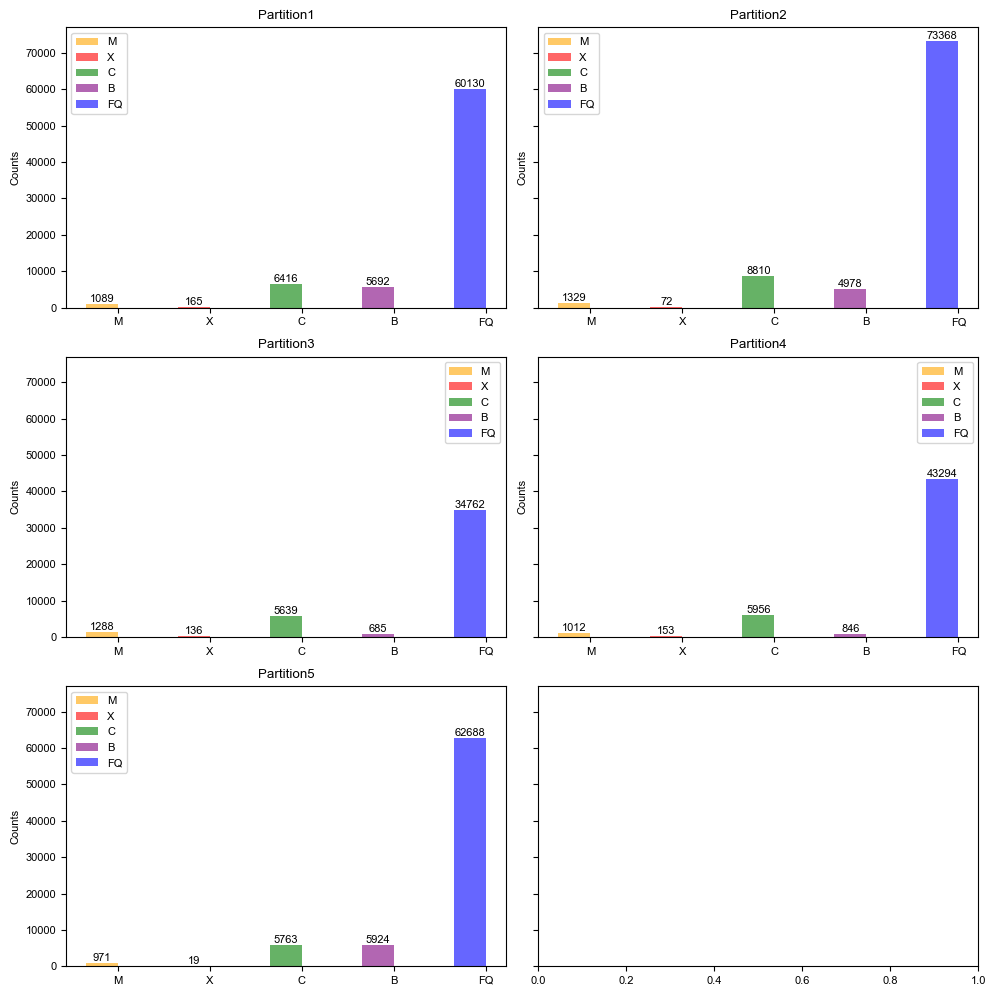

In [212]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(3,2, sharey=True,
  figsize=(10, 10))

rects = []

def autolabel(rects,i,j):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax[i,j].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

for i in range(1,6):

    # Create dictionary for counts of each flare type
    flare_types = {"M": 0, "X": 0, "C": 0, "B": 0, "FQ": 0}

    # For each objects flare type sort into M, X, C, B, or FQ, otherwise skip
    for j in labels[i-1]['FLARE_TYPE']:
        if "M" in j:
            flare_types["M"] +=1
        elif "X" in j:
            flare_types["X"] +=1
        elif "C" in j:
            flare_types["C"] +=1
        elif "B" in j:
            flare_types["B"] +=1
        elif "FQ" in j:
            flare_types["FQ"] +=1
        else:
            continue

    x = np.arange(len(flare_types.keys()))  # the label locations
    width = 0.35  # the width of the bars

    if i < 3:
        rects.append(ax[0,i-1].bar(x - width/2, flare_types.values(), width, label=flare_types.keys(), \
                                   color=['orange','red','green','purple','blue'], alpha=0.6))
        ax[0,i-1].set_ylabel('Counts')
        ax[0,i-1].set_title('Partition' + str(i))
        ax[0,i-1].set_xticks(x)
        ax[0,i-1].set_xticklabels(flare_types.keys())
        ax[0,i-1].legend()
        autolabel(rects[i-1],0,i-1)
        
    elif i < 5:
        rects.append(ax[1,i-3].bar(x - width/2, flare_types.values(), width, label=flare_types.keys(), \
                                   color=['orange','red','green','purple','blue'], alpha=0.6))
        ax[1,i-3].set_ylabel('Counts')
        ax[1,i-3].set_title('Partition' + str(i))
        ax[1,i-3].set_xticks(x)
        ax[1,i-3].set_xticklabels(flare_types.keys())
        ax[1,i-3].legend()
        autolabel(rects[i-1],1,i-3)
        
    else:
        rects.append(ax[2,i-5].bar(x - width/2, flare_types.values(), width, label=flare_types.keys(), \
                                   color=['orange','red','green','purple','blue'], alpha=0.6))
        ax[2,i-5].set_ylabel('Counts')
        ax[2,i-5].set_title('Partition' + str(i))
        ax[2,i-5].set_xticks(x)
        ax[2,i-5].set_xticklabels(flare_types.keys())
        ax[2,i-5].legend()
        autolabel(rects[i-1],2,i-5)

    

    fig.tight_layout()



plt.show()


# Missing value Exploration

In [208]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [26]:
abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

null_count = [0,0,0,0,0]
non_null_count = [0,0,0,0,0]
null_count_per_feature = np.zeros((5,25), dtype=int)

for i in range(1,6):
    partition = np.array(data[i-1])
    
    for j in range(1,partition.shape[2]):
        mvts = partition[:,:, j-1]
        for m in range(1,26):
            for n in range (1,61):
                if (mvts[n-1,m-1] == 0.0):
                    null_count[i-1] += 1
                    null_count_per_feature[i-1,m-1] += 1
                else:
                    non_null_count[i-1] += 1
    
    print("Partition" + str(i) + ":")
    print("null counts in P" + str(i) + ": " + str(null_count[i-1]))
    print("non-null counts in P"+ str(i) + ": " + str(non_null_count[i-1]))
    for x in range(1,26):
        print(abt_header[x-1] + ": " + str(null_count_per_feature[i-1,x-1]))
    
    print("\n")

Partition1:
null counts in P1: 2487130
non-null counts in P1: 107749370
Timestamp: 0
R_VALUE: 2399204
TOTUSJH: 652
TOTBSQ: 652
TOTPOT: 652
TOTUSJZ: 652
ABSNJZH: 652
SAVNCPP: 652
USFLUX: 652
TOTFZ: 652
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 81406
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 652
MEANJZD: 0
MEANALP: 0
TOTFX: 652


Partition2:
null counts in P2: 4002443
non-null counts in P2: 128831557
Timestamp: 0
R_VALUE: 2934858
TOTUSJH: 93300
TOTBSQ: 93300
TOTPOT: 93300
TOTUSJZ: 93300
ABSNJZH: 93300
SAVNCPP: 93300
USFLUX: 93300
TOTFZ: 93300
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 134585
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 93300
MEANJZD: 0
MEANALP: 0
TOTFX: 93300


Partition3:
null counts in P3: 1472336
non-null counts in P3: 62291164
Timestamp: 0
R_VALUE: 1361036
TOTUSJH: 2718
TOTBSQ: 2718
TOTPOT: 2718
TOTUSJZ: 2718
ABSNJZH: 2718
SAVNCPP: 2725
USFLUX: 2718
TOTFZ: 2718
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0

# MVTS visualization

In [192]:
sample_flare_index = [0,0,0]

for i in range(0,len(labels[0]['FLARE_CLASS'])):
    if labels[0]['FLARE_CLASS'][i] == 'X':
        sample_flare_index[0] = i
    elif labels[0]['FLARE_CLASS'][i] == 'M':
        sample_flare_index[1] = i
    elif labels[0]['FLARE_CLASS'][i] == 'C':
        sample_flare_index[2] = i
    
    count = 0
    for j in range(0,3):
        if sample_flare_index[j] != 0:
            count += 1
    if count == 3:
        break
       

In [207]:
from scipy.stats import zscore

def plot_time_series_class(data, timestamp, class_name, ax, n_steps=5):
    
    time_series_df = pd.DataFrame(data)
    
    time_series_df[0] = zscore(time_series_df[0])
    time_series_df[1] = zscore(time_series_df[1])
    time_series_df[2] = zscore(time_series_df[2])

    smooth_path = time_series_df[0].rolling(n_steps).mean()
    ax.plot(smooth_path, linestyle='-', linewidth=0.5, label='X Flare', color='red')
    
    smooth_path = time_series_df[1].rolling(n_steps).mean()
    ax.plot(smooth_path, linestyle='-', linewidth=0.5, label='M Flare', color='orange')
    
    smooth_path = time_series_df[2].rolling(n_steps).mean()
    ax.plot(smooth_path, linestyle='-', linewidth=0.5, label='C Flare', color='green')
    

    ax.set_ylabel(class_name)
    ax.legend();

Class: X
Start Time: 2011-03-09 01:36  and  End Time: 2011-03-09 13:24
Class: M
Start Time: 2011-10-01 09:36  and  End Time: 2011-10-01 21:24
Class: C
Start Time: 2011-08-03 07:12  and  End Time: 2011-08-03 19:00


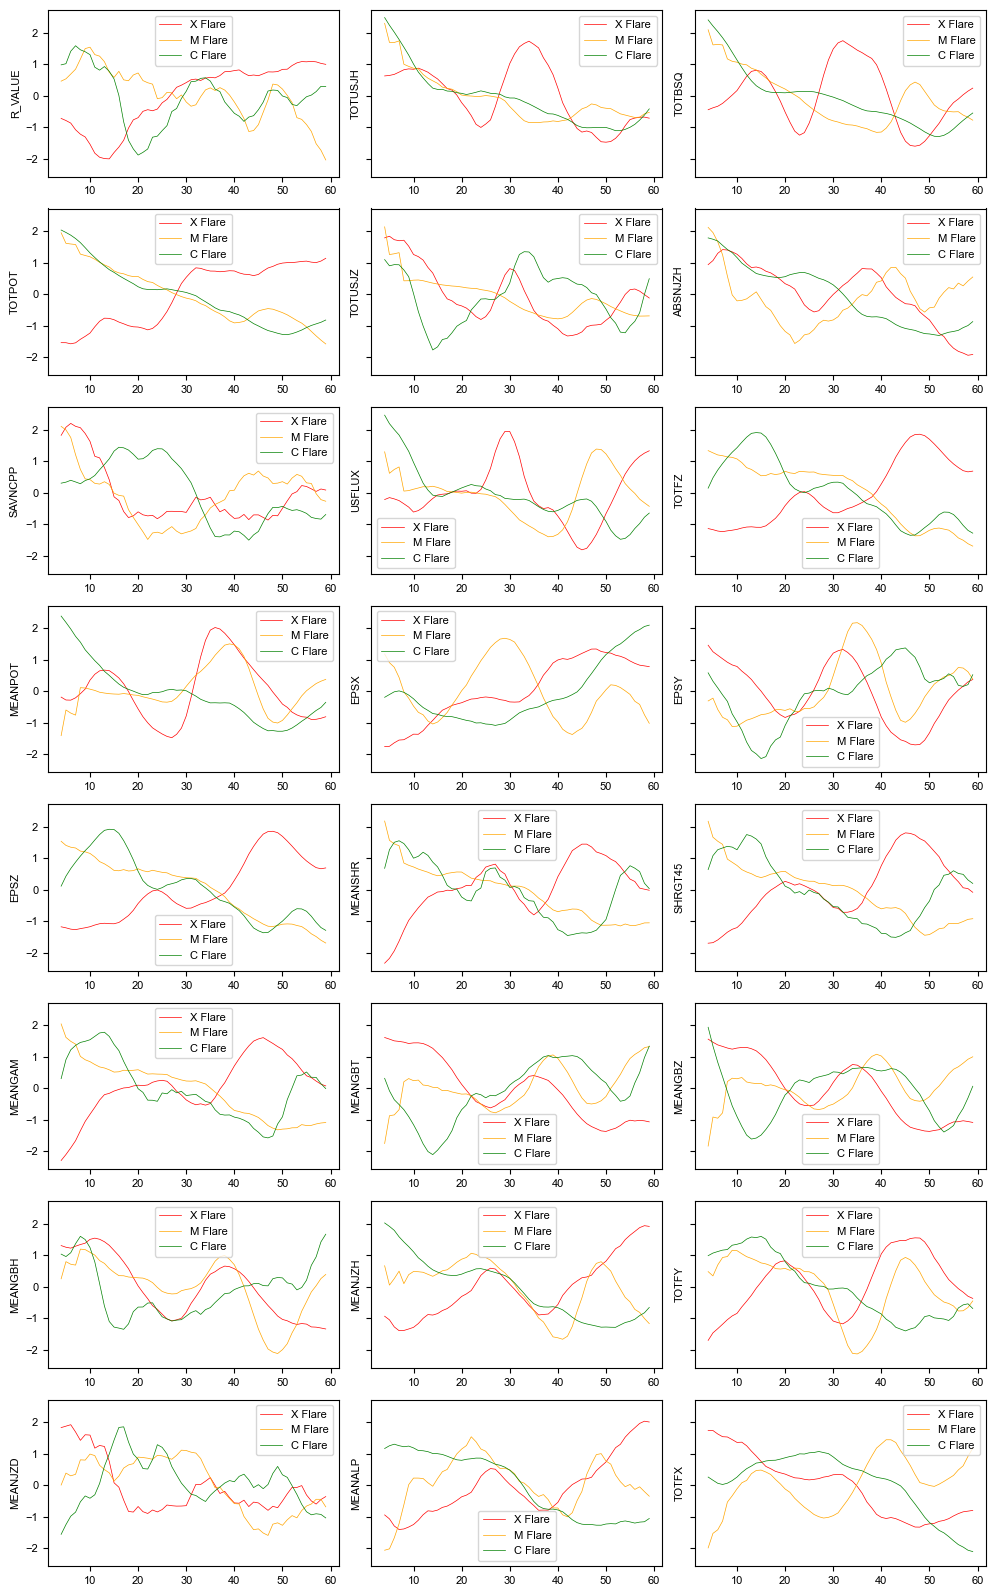

In [209]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

fig, axs = plt.subplots(8,3, sharey=True,
  figsize=(10, 16))

sample_flare_mvts = np.zeros((60,25,3))

for i in range(0,3):
    sample_flare_mvts[:,:, i] = np.array(data[0])[:,:, sample_flare_index[i]]
    
    timestamp = sample_flare_mvts[:,0, i]

    start_time = str(timestamp[0])[0:4] + '-' + str(timestamp[0])[4:6] + '-' + str(timestamp[0])[6:8] \
                + ' ' + str(timestamp[0])[8:10] + ":" + str(timestamp[0])[10:12]

    end_time = str(timestamp[59])[0:4] + '-' + str(timestamp[59])[4:6] + '-' + str(timestamp[59])[6:8] \
                + ' ' + str(timestamp[59])[8:10] + ":" + str(timestamp[59])[10:12]

    if i == 0:
        print('Class: X') 
    elif i == 1:
        print('Class: M') 
    else:
        print('Class: C') 
        
    print('Start Time: ' + start_time + '  and  End Time: ' + end_time)



for i, cls in enumerate(abt_header):
    ax = axs.flat[i]
    data = sample_flare_mvts[:,i+1,:]
    
    plot_time_series_class(data, timestamp, abt_header[i], ax)

fig.tight_layout();
    

# Undersampling

# KNN Imputation 

# Z Normalization

# Train Test Split

In [ ]:
Partion 1 to 3: Train, Partition 4: Validation, and partition5: Test

# First round ML

ROCKET, LSTM, GRU, RNN, TSF

# DA

SMOTE, ADASYN, TimeGAN, Noise Injection (On minority classes {X and M})

# Second round ML

ROCKET, LSTM, GRU, RNN, TSF (On Augmented data)

# Comparison

# Visualization